**Name:** EDUARDO WILLIAMS

**Student code:** C0896405

**Date:** July 9, 2024

In [44]:
# importing libraries
import pandas as pd
import numpy  as np

from matplotlib import pyplot as plt

# Importing tensorflow libraries
import tensorflow as tf
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.models              import Sequential
from tensorflow.keras.layers              import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets            import fashion_mnist
from tensorflow.keras.callbacks           import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**FASHION MNIST dataset**

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

**1. Loading the Fashion MNIST dataset from Keras**

In [45]:
# This dataset return 2 tuples of NumPy arrays: (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

**2. Data exploring**

In [46]:
# x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data
# y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (60000,) for the training data
# x_test:  uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data
# y_test:  uint8 NumPy array of labels (integers in range 0-9) with shape (10000,) for the test data

# verifying shapes
print ("x_train shape -->", x_train.shape)
print ("y_train shape -->", y_train.shape)
print ("x_test  shape -->", x_test.shape)
print ("y_test  shape -->", y_test.shape)

x_train shape --> (60000, 28, 28)
y_train shape --> (60000,)
x_test  shape --> (10000, 28, 28)
y_test  shape --> (10000,)


In [47]:
# verifying unique classes
print(pd.DataFrame(y_train)[0].unique())

[9 0 3 2 7 5 1 6 4 8]


**Classes**

0 --> T-shirt/top

1 --> Trouser

2 --> Pullover

3 --> Dress

4 --> Coat

5 --> Sandal

6 --> Shirt

7 --> Sneaker

8 --> Bag

9 --> Ankle boot

In [48]:
# Classes dictionary
fashion_mnist_classes = {0: "T-shirt/top",
                         1: "Trouser",
                         2: "Pullover",
                         3: "Dress",
                         4: "Coat",
                         5: "Sandal",
                         6: "Shirt",
                         7: "Sneaker",
                         8: "Bag",
                         9: "Ankle boot"}

In [52]:
# Counting classes in train
classes, counts = np.unique(y_train, return_counts = True)
classes_dist = dict(zip(classes, counts))
print (classes_dist)

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


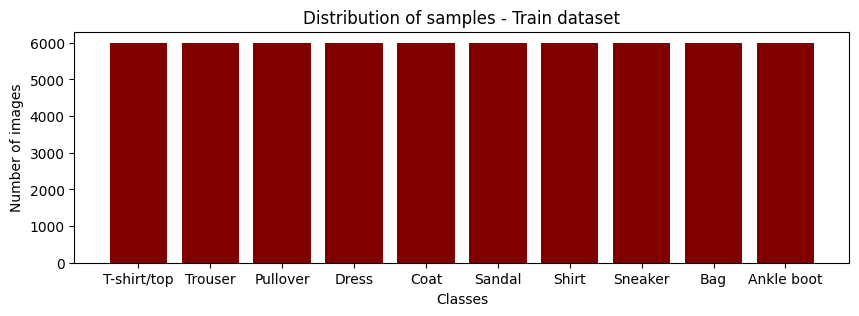

In [54]:
# showing samples distribution
plt.figure(figsize = (10, 3))
plt.bar(classes_dist.keys(),
        classes_dist.values(),
        tick_label = [fashion_mnist_classes[i] for i in classes_dist.keys()],
        color = 'maroon')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Distribution of samples - Train dataset')
plt.show()

**3. Data pre-processing**

In [55]:
# reshaping datasets to have a single channel
width, height, channels = x_train.shape[1], x_train.shape[2], 1
x_train = x_train.reshape((x_train.shape[0], width, height, channels))
x_test  = x_test.reshape((x_test.shape[0], width, height, channels))

In [56]:
# transforming train and test target to categorical
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

In [57]:
# verifying new shapes
print ("x_train shape -->", x_train.shape)
print ("y_train shape -->", y_train.shape)
print ("x_test  shape -->", x_test.shape)
print ("y_test  shape -->", y_test.shape)

x_train shape --> (60000, 28, 28, 1)
y_train shape --> (60000, 10)
x_test  shape --> (10000, 28, 28, 1)
y_test  shape --> (10000, 10)


In [58]:
# veritying scale of pixel values
print('Train min=%.3f, max=%.3f' % (x_train.min(), x_train.max()))
print('Test min=%.3f, max=%.3f' % (x_test.min(), x_test.max()))

Train min=0.000, max=255.000
Test min=0.000, max=255.000


In [59]:
# scaling the pixel values to a range between 0 and 1
x_train = x_train / 255.0
x_test  = x_test  / 255.0

In [60]:
# creating the image data generator for visualization
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_iterator = datagen.flow(x_train, y_train, batch_size=64)
test_iterator  = datagen.flow(x_test,  y_test,  batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

Batches train=938, test=157


In [61]:
# testing the image data generator
x_batch, y_batch = next(train_iterator)
print('Batch shape=%s, min=%.3f, max=%.3f' % (x_batch.shape, x_batch.min(), x_batch.max()))

Batch shape=(64, 28, 28, 1), min=0.000, max=0.004


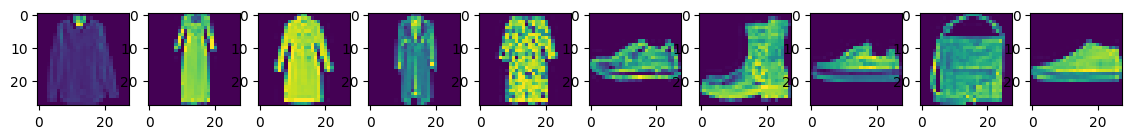

In [62]:
# showing some train images
batch_img = next(train_iterator)

fig, ax = plt.subplots(ncols = 10, figsize = (14,14))

for idx in range(10):
    sample_image = batch_img[0][idx]
    ax[idx].imshow(sample_image)

**4. Building an Artificial Neural Network**

In [74]:
model = Sequential()                                  # defining a Sequential model
model.add(Input(shape=(width, height, channels)))     # adding Input layer (28,28,1)
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))            # output layer uses softmax since they are 10 classes

**5. Compiling the model**

In [75]:
# we use categorical_crossentropy loss since categories are in one hot encoding format
# besides, accuracy metric is added
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**6. Training and evaluating the model**

In [76]:
# defining early_stopping callback
# it is useful for stopping epochs if the selected metric (accuracy in this case) is not improving anymore
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 5, min_delta = 0.05, verbose = 1)

In [77]:
# defining model_checkpoint callback
# it is useful for evaluating and saving automatically the best models while training
model_checkpoint = ModelCheckpoint(filepath       = "model-{epoch:02d}-{accuracy:.2f}.keras",
                                   monitor        = 'val_accuracy',
                                   mode           = 'max',
                                   save_best_only = True)

In [78]:
# fitting the model and saving history
# x_train --> train dataset
# y_train --> train target
# epochs  --> number of epochs
# validation_split --> define 20% of the dataset for validation tasks
# callbacks --> add early_stopping, model_checkpoint callbacks
hist = model.fit(x_train,
                 y_train,
                 epochs = 20,
                 validation_split=0.2,
                 callbacks = [early_stopping, model_checkpoint])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7502 - loss: 0.6859 - val_accuracy: 0.8708 - val_loss: 0.3610
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8772 - loss: 0.3400 - val_accuracy: 0.8844 - val_loss: 0.3184
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8954 - loss: 0.2840 - val_accuracy: 0.8983 - val_loss: 0.2759
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9083 - loss: 0.2493 - val_accuracy: 0.9022 - val_loss: 0.2685
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9194 - loss: 0.2216 - val_accuracy: 0.9050 - val_loss: 0.2594
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9250 - loss: 0.2025 - val_accuracy: 0.9032 - val_loss: 0.2674
Epoch 6: early stopping


In [79]:
# showing epochs history
hist.history

{'accuracy': [0.819979190826416,
  0.8806458115577698,
  0.8974166512489319,
  0.9082916378974915,
  0.9175000190734863,
  0.9247291684150696],
 'loss': [0.490330308675766,
  0.3309483826160431,
  0.2809426784515381,
  0.25019916892051697,
  0.22519774734973907,
  0.20298883318901062],
 'val_accuracy': [0.8708333373069763,
  0.8844166398048401,
  0.8983333110809326,
  0.9022499918937683,
  0.9049999713897705,
  0.903166651725769],
 'val_loss': [0.3610460162162781,
  0.318380206823349,
  0.2758677303791046,
  0.26846712827682495,
  0.259351909160614,
  0.2673760950565338]}

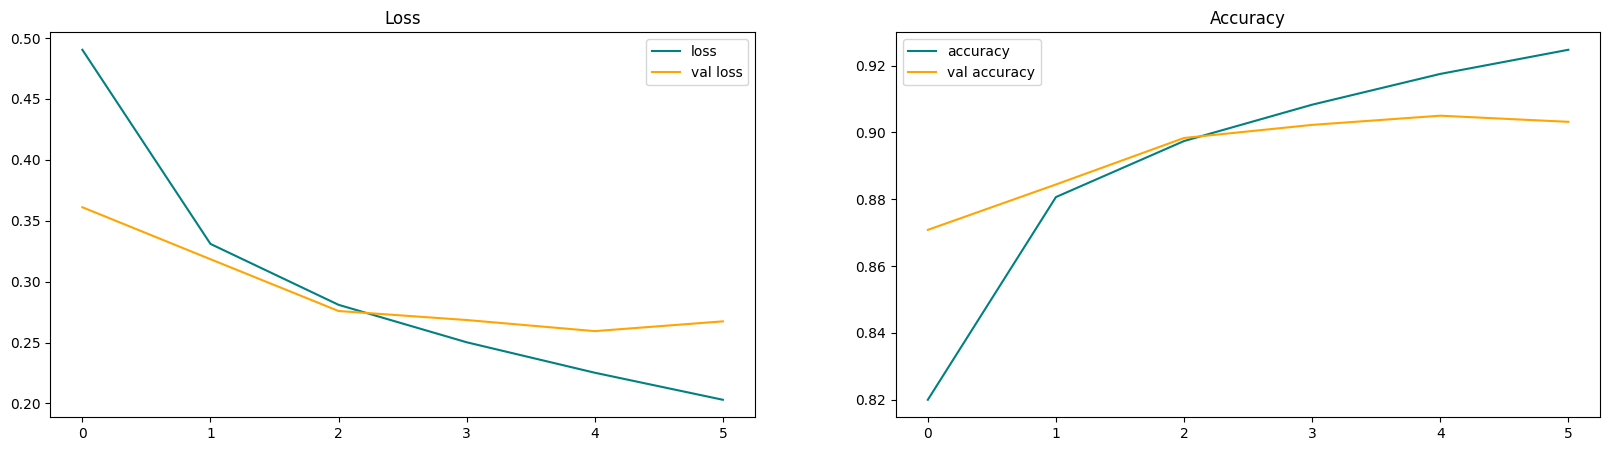

In [80]:
# ploting total loss and accuracy for train and validation datasets
fig, ax = plt.subplots(ncols=2, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val accuracy')
ax[1].title.set_text('Accuracy')
ax[1].legend()

plt.show()

**7. Making predictions on Test dataset**

In [82]:
# evaluating the model
test_loss, test_acc = model.evaluate(test_iterator, steps=len(test_iterator), verbose=2)
print(f'\nLoss ==> {test_loss}')
print(f'\nAccuracy ==> {test_acc}')


157/157 - 0s - 3ms/step - accuracy: 0.1000 - loss: 4.9055

Loss ==> 4.905470371246338

Accuracy ==> 0.10000000149011612


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


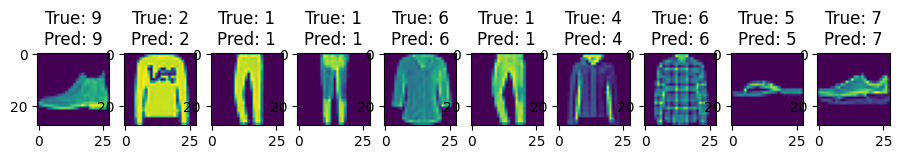

In [86]:
# Predicting and drawing a sample of test dataset
y_pred = model.predict(x_test)

plt.figure(figsize=(11, 11))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i])
    plt.title(f'True: {np.argmax(y_test[i])}\nPred: {np.argmax(y_pred[i])}')
    #plt.axis('off')
plt.show()